In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/kol')

import tensorflow as tf
import numpy as np
from layers import BilinearInterpolation
from matplotlib import pyplot as plt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In summary, this function sets up the initial weights and biases for an affine transformation in a **Spatial Transformer Network** , with a particular focus on the scaling (zoom) component of the transformation. The zeros in weights suggest that the network would learn the appropriate values during training, and the biases are initialized to control the default zoom level.

In [2]:
def initialize_weights(input_nodes: int, default_zoom: float):
    biases = np.zeros((2, 3), dtype='float32') # this line creates a 2x3 matrix filled with zeros.
    biases[0, 0] = default_zoom # these lines set the first and the fifth elements of the biases matrix to default_zoom.
    biases[1, 1] = default_zoom # ...these lines
    weights = np.zeros((input_nodes, 6), dtype='float32') # this creates a matrix of weights with dimensions input_nodes x 6, also filled with zeros.

    return [weights, biases.flatten()]

Example of, what the function output:

In [3]:
output = initialize_weights(32, 0.5)
print(output)

[array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0

The final layer is particularly important as it outputs the parameters for the spatial transformation, which are then applied to the input data in the Spatial Transformer Network. The model's architecture is designed to process input images, extract relevant spatial features, and output transformation parameters.

The size of the weight matrix as (32, 6) is determined by the number of features outputted by the previous layer (32) and the number of parameters needed for the affine transformation (6). This setup allows the network to learn how to transform the input data spatially based on the features extracted by the earlier layers.

So we use the function such that it allows the last 32 neurons to affact the weights of the matrix - the 2*3 matrix that describes the transformation. In this way it can learn how to transform the matrix - and therefore how to change the input, to make better prediction. This is a seperate CNN, where the network can learn how to transform the input images.

In [4]:
def build_loc_model(default_zoom):
    loc_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, kernel_size=7),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(10, kernel_size=5),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'), # 32 must match the below function call
        tf.keras.layers.Dense(6, activation='linear',
                              weights=initialize_weights(32, default_zoom)), # this means for each of the 6 neurons in the current layer, there are 32 weights, one for each connection from the 32 neurons in the preceding layer.
        ])

    return loc_model

This function takes two parameters:

**sampling_shape:**

The shape of the input data (height, width of the images).

**num_classes:**

The number of classes for the classification task.

In [5]:
def build_cnn_model(sampling_shape, num_classes):
    cnn_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(10, kernel_size=5, input_shape=(*sampling_shape, 1)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(20, kernel_size=5),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
        ], name='classifier')

    return cnn_model

**Function Definition:**

def build_stn_model(input_shape, sampling_shape, num_classes, default_zoom):

This function takes four parameters:

**input_shape:** The shape of the input images.

**sampling_shape:** The shape to which the images will be transformed.

**num_classes:** The number of classes for classification tasks.

**default_zoom:** A parameter used for initializing the localization network.

<br>

x = BilinearInterpolation(sampling_shape)([image, x])

The BilinearInterpolation layer applies the learned transformation to the input image, resizing it to sampling_shape. This process involves bilinear interpolation, which is a method of image scaling where the output pixel value is a weighted average of pixels in the nearest 2x2 neighborhood.

<br>

In summary, the build_stn_model function builds a Spatial Transformer Network that combines a localization network for learning spatial transformations, a mechanism for applying these transformations, and a conventional CNN for classification. The STN's ability to transform the input image spatially before classification makes it a powerful tool for handling variations in the input data.

In [6]:
def build_stn_model(input_shape, sampling_shape, num_classes, default_zoom):
    loc_model = build_loc_model(default_zoom) # this creates the localization model (loc_model) using the build_loc_model function. The localization model learns the parameters for the spatial transformation needed.
    cnn_model = build_cnn_model(sampling_shape, num_classes) # constructs a CNN model for classification using the build_cnn_model function.

    image = tf.keras.layers.Input(shape=(input_shape)) # this defines the input layer of the STN with the specified input_shape
    x = loc_model(image) # this line applies the localization model to the input image. The output x is a vector representing the spatial transformation parameters.
    # applies a learned spatial transformation "x" to the input "image",
    # resizing it to "sampling_shape" using bilinear interpolation,
    # which is then ready for further classification by a CNN.
    x = BilinearInterpolation(sampling_shape)([image, x])
    spatial_transform = tf.keras.models.Model(
        inputs=image, outputs=x, name='spatial_transformer',
    ) # this creates a model that encapsulates the spatial transformation process.

# The final STN model is a sequential combination of the spatial transformer and the CNN model. The spatially transformed image output from the spatial transformer is passed as input to the CNN model.

    stn_model = tf.keras.models.Sequential([
        spatial_transform,
        cnn_model,
        ])
    #Note the cnn_model takes the output from the spatial_transformer
    #(the transformed image) as input.
    return stn_model

In [7]:
(x_train, y_train), (x_test,
                     y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

enlarged_shape = (60, 60)
diff_x = enlarged_shape[1] - 28
diff_y = enlarged_shape[0] - 28


def enlargen_images(images):
    images_mod = []
    for x in images:
        mask = np.zeros(enlarged_shape)
        offset_x, offset_y = np.random.choice(range(diff_x)), np.random.choice(
            range(diff_y))
        mask[offset_y:(offset_y + 28), offset_x:(offset_x + 28)] = x
        images_mod.append(mask)
    return np.array(images_mod)


x_train_mod = enlargen_images(x_train)
x_test_mod = enlargen_images(x_test)

print(x_train.shape, x_train_mod.shape, y_train.shape, x_test.shape,
      x_test_mod.shape, y_test.shape)

(60000, 28, 28) (60000, 60, 60) (60000,) (10000, 28, 28) (10000, 60, 60) (10000,)


In [8]:
# Building two Spatial Transformer Network models with different zoom levels
stn_model = build_stn_model((*enlarged_shape, 1), (28, 28), 10, 1.0)  # STN model with default zoom
stn_model_zoom = build_stn_model((*enlarged_shape, 1), (28, 28), 10, 0.5)  # STN model with zoom level 0.5

# Getting the output of the spatial transformer layer before training
out_pre_train = stn_model.get_layer('spatial_transformer')(x_test_mod[0:1]).numpy()[0, :, :, 0]
out_pre_train_zoom = stn_model_zoom.get_layer('spatial_transformer')(x_test_mod[0:1]).numpy()[0, :, :, 0]

# Compiling both models with the Adam optimizer and sparse categorical crossentropy loss
stn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
stn_model_zoom.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the first model for 1 epoch
hist = stn_model.fit(x_train_mod, y_train, validation_data=(x_test_mod, y_test), epochs=3, batch_size=128, verbose=0)

# Training the second model for 1 epochs
hist_zoom = stn_model_zoom.fit(x_train_mod, y_train, validation_data=(x_test_mod, y_test), epochs=3, batch_size=128, verbose=0)

# Getting the output of the spatial transformer layer after training
out_post_train = stn_model.get_layer('spatial_transformer')(x_test_mod[0:1]).numpy()[0, :, :, 0]
out_post_train_zoom = stn_model_zoom.get_layer('spatial_transformer')(x_test_mod[0:1]).numpy()[0, :, :, 0]

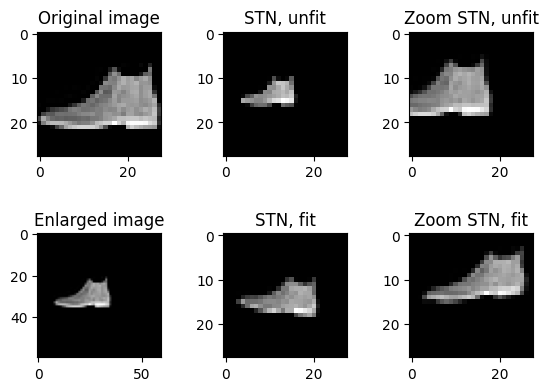

In [9]:
# Define a function for plotting the results
def plot():
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
    ax1.imshow(x_test[0], cmap='gray')
    ax1.set_title('Original image')
    ax4.imshow(x_test_mod[0], cmap='gray')
    ax4.set_title('Enlarged image')
    ax2.imshow(out_pre_train, cmap='gray')
    ax2.set_title('STN, unfit')
    ax5.imshow(out_post_train, cmap='gray')
    ax5.set_title('STN, fit')
    ax3.imshow(out_pre_train_zoom, cmap='gray')
    ax3.set_title('Zoom STN, unfit')
    ax6.imshow(out_post_train_zoom, cmap='gray')
    ax6.set_title('Zoom STN, fit')
    fig.subplots_adjust(wspace=0.5)
    plt.show()

# Execute the plot function
plot()

In [10]:
stn_model.evaluate(x_test_mod, y_test)
stn_model_zoom.evaluate(x_test_mod, y_test);

313/313 [==============================] - 2s 5ms/step - loss: 0.4742 - accuracy: 0.8252


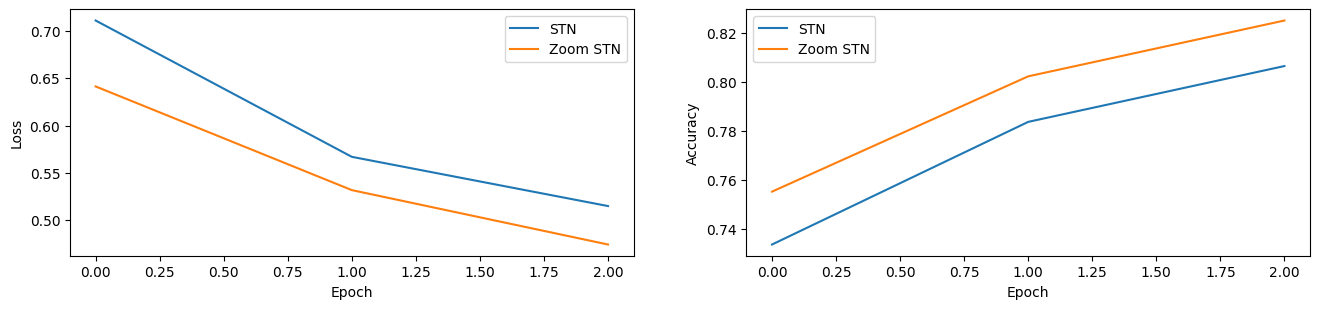

In [11]:
fig = plt.figure(figsize=plt.figaspect(0.1 * 2))

ax = fig.add_subplot(1, 2, 1)
ax.plot(hist.history['val_loss'], label='STN')
ax.plot(hist_zoom.history['val_loss'], label='Zoom STN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist.history['val_accuracy'], label='STN')
ax.plot(hist_zoom.history['val_accuracy'], label='Zoom STN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()